# Correlated shocks

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Domestic discount factor shock](#toc2_)    
  - 2.1. [HANK](#toc2_1_)    
  - 2.2. [RANK](#toc2_2_)    
  - 2.3. [Covariance decomposition](#toc2_3_)    
- 3. [IRFs](#toc3_)    
  - 3.1. [Only HANK](#toc3_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["NUMBA_PARFOR_MAX_TUPLE_SIZE"] = "200"

import numpy as np
import pandas as pd
import numba as nb
from scipy import optimize
nb.set_num_threads(4)
from IPython.display import display

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import figs
from IHANKModel import create_model

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model_HANK = create_model('HANK')

HANK


In [3]:
model_RANK = create_model('RANK',par={'HH_type':'RA-IM'})

RANK


In [4]:
def covariance_decomposition(model,T_max=17,do_print=False):
 
    par = model.par
    ss = model.ss
    path = model.path
    data = model.data

    dY_data = data.LP_IRFS_SOE_smoothed['Y']*100
    dC_data = data.LP_IRFS_SOE_smoothed['C']*100

    var_Y_data = np.sum(dY_data[:T_max]**2)
    var_C_data = np.sum(dC_data[:T_max]**2)
    cov_Y_C_data = np.sum(dY_data[:T_max]*dC_data[:T_max])

    if do_print: print(f'{model.name}:')

    dY = (path.Y-ss.Y)*par.scale/ss.Y*100
    dC = (path.C-ss.C)*par.scale/ss.C*100

    var_Y = np.sum(dY[:T_max]**2)
    var_C = np.sum(dC[:T_max]**2)
    cov_Y_C = np.sum(dY[:T_max]*dC[:T_max])

    if do_print: print(f'{var_Y/var_Y_data = :5.2f}, {var_C/var_C_data = :5.2f}, {cov_Y_C/cov_Y_C_data = :5.2f}')
    if do_print: print('')

    error = (var_C-var_C_data)**2
    if cov_Y_C < 0:
        error += 1000*np.abs(cov_Y_C)

    return error,var_Y/var_Y_data,var_C/var_C_data,cov_Y_C/cov_Y_C_data

## 2. <a id='toc2_'></a>[Domestic discount factor shock](#toc0_)

In [5]:
class StopIteration(Exception): pass 
def obj(x,model):

    print(x,end='')

    shocks = model.get_foreign_shocks_from_LP()

    shockvalues = np.zeros(model.par.T)
    for t in range(model.par.T):

        if t <= 0:
            x_lag = 0.0

        else:
            x_lag = shockvalues[t-1]

        if t <= 1:
            x_lag2 = 0.0
            
        else:
            x_lag2 = shockvalues[t-2]            

        shockvalues[t] = x[1]*x_lag 
        
        if x.size > 2: shockvalues[t] = x[2]*x_lag2
        if t == 0: shockvalues[t] += x[0]

    shocks['deps_beta'] = shockvalues
    
    model.find_transition_path(shocks=shocks,do_end_check=False)

    base_dC = model.data.LP_IRFS_SOE_smoothed['C']
    dC = (model.path.C[:20]-model.ss.C)/model.ss.C
    #error = np.sum(np.abs(model.par.scale*dC-base_dC))

    error,_,_,_ = covariance_decomposition(model)
    print(f' -> {error:12.8f}')
    
    if error < 1e-4: raise StopIteration

    return error

def find_eps_beta(model):

    x0 = np.array([1.05*1e-6,0.965])
    
    try:
        result = optimize.minimize(obj,x0,bounds=((0.0,1e-4),(0.01,0.99)),args=(model),method='Nelder-Mead')    
        obj(result.x,model)
    except Exception:
        pass

### 2.1. <a id='toc2_1_'></a>[HANK](#toc0_)

In [6]:
model_HANK_eps_beta = model_HANK.copy(name='HANK_eps_beta')
find_eps_beta(model_HANK_eps_beta)

[1.05e-06 9.65e-01]

 ->  39.19309709
[1.1025e-06 9.6500e-01]

 ->  46.33676523
[1.05e-06 9.90e-01]

 -> 542.49546180
[1.1025e-06 9.4000e-01]

 ->   6.79959444
[1.12875e-06 9.15000e-01]

 ->   1.00367321
[1.07625e-06 9.15000e-01]

 ->   0.72211102
[1.063125e-06 8.900000e-01]

 ->   0.00026891
[1.141875e-06 8.400000e-01]

 ->   0.55392313
[1.07625e-06 8.15000e-01]

 ->   1.04823264
[1.115625e-06 8.900000e-01]

 ->   0.00680822
[1.036875e-06 9.400000e-01]

 ->   5.22567805
[1.115625e-06 8.650000e-01]

 ->   0.19105371
[1.063125e-06 9.150000e-01]

 ->   0.65956497
[1.1025e-06 8.7750e-01]

 ->   0.05236388
[1.07625e-06 9.02500e-01]

 ->   0.13608890
[1.0959375e-06 8.8375000e-01]

 ->   0.01118253
[1.0828125e-06 8.9625000e-01]

 ->   0.03606904
[1.09265625e-06 8.86875000e-01]

 ->   0.00148505
[1.04015625e-06 8.86875000e-01]

 ->   0.01749575
[1.09675781e-06 8.89218750e-01]

 ->   0.00072072
[1.06722656e-06 8.92343750e-01]

 ->   0.00261082
[1.08629883e-06 8.88242187e-01]

 ->   0.00028396
[1.05266602e-06 8.89023437e-01]

 ->   0.00355369
[1.08573486e-06 8.89169922e-01]

 ->   0.00002597


### 2.2. <a id='toc2_2_'></a>[RANK](#toc0_)

In [7]:
model_RANK_eps_beta = model_RANK.copy(name='RANK_eps_beta')
find_eps_beta(model_RANK_eps_beta)

[1.05e-06 9.65e-01]

 ->  52.78210409
[1.1025e-06 9.6500e-01]

 ->  70.03561335
[1.05e-06 9.90e-01]

 -> 2071.05888377
[1.1025e-06 9.4000e-01]

 ->   0.14115327
[1.12875e-06 9.15000e-01]

 ->   3.93551377
[1.05e-06 9.40e-01]

 ->   0.00006103


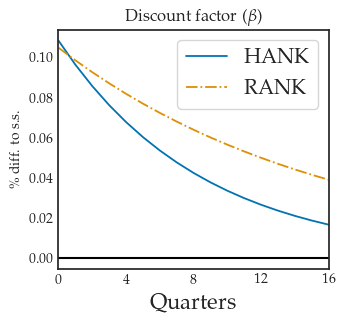

In [8]:
fig = figs.show_IRFs(models=[model_HANK_eps_beta,model_RANK_eps_beta],paths=['eps_beta'],
                     lstyles=['-','-.'],labels=['HANK','RANK'],figsize=[3.7,3.5])  

fig.savefig(f'plots/correlated_shocks_eps_beta.pdf')

### 2.3. <a id='toc2_3_'></a>[Covariance decomposition](#toc0_)

In [9]:
var_Y_rel = np.nan*np.ones(4)
var_C_rel = np.nan*np.ones(4)
cov_Y_C_rel = np.nan*np.ones(4)

In [10]:
for i,model in enumerate([
        model_HANK,model_HANK_eps_beta,
        model_RANK,model_RANK_eps_beta
        ]):
    _,var_Y_rel[i],var_C_rel[i],cov_Y_C_rel[i] = covariance_decomposition(model,do_print=True)

HANK:
var_Y/var_Y_data =  1.17, var_C/var_C_data =  0.59, cov_Y_C/cov_Y_C_data =  0.73

HANK_eps_beta:
var_Y/var_Y_data =  1.28, var_C/var_C_data =  1.00, cov_Y_C/cov_Y_C_data =  1.05

RANK:
var_Y/var_Y_data =  0.73, var_C/var_C_data =  0.10, cov_Y_C/cov_Y_C_data = -0.08

RANK_eps_beta:
var_Y/var_Y_data =  0.85, var_C/var_C_data =  1.00, cov_Y_C/cov_Y_C_data =  0.68



**Write latex table:**

In [11]:
df = pd.DataFrame({r'$\frac{\text{var}(Y)}{\text{var}(Y^{\text{data}})}$':var_Y_rel,
              r'$\frac{\text{var}(C)}{\text{var}(C^{\text{data}})}$':var_C_rel,
              r'$\frac{\text{cov}(C,Y)}{\text{cov}(C^{\text{data}},Y^{\text{data}})}$\vspace{1mm}':cov_Y_C_rel},
             index=[r'\textbf{HANK}: Foreign demand', r'+ Domestic demand', 
                    r'\textbf{RANK}: Foreign Demand', r'+ Domestic demand'])

df = df.style.format(precision=2)
df.to_latex('tables/correlated_shocks.txt',hrules=True)

## 3. <a id='toc3_'></a>[IRFs](#toc0_)

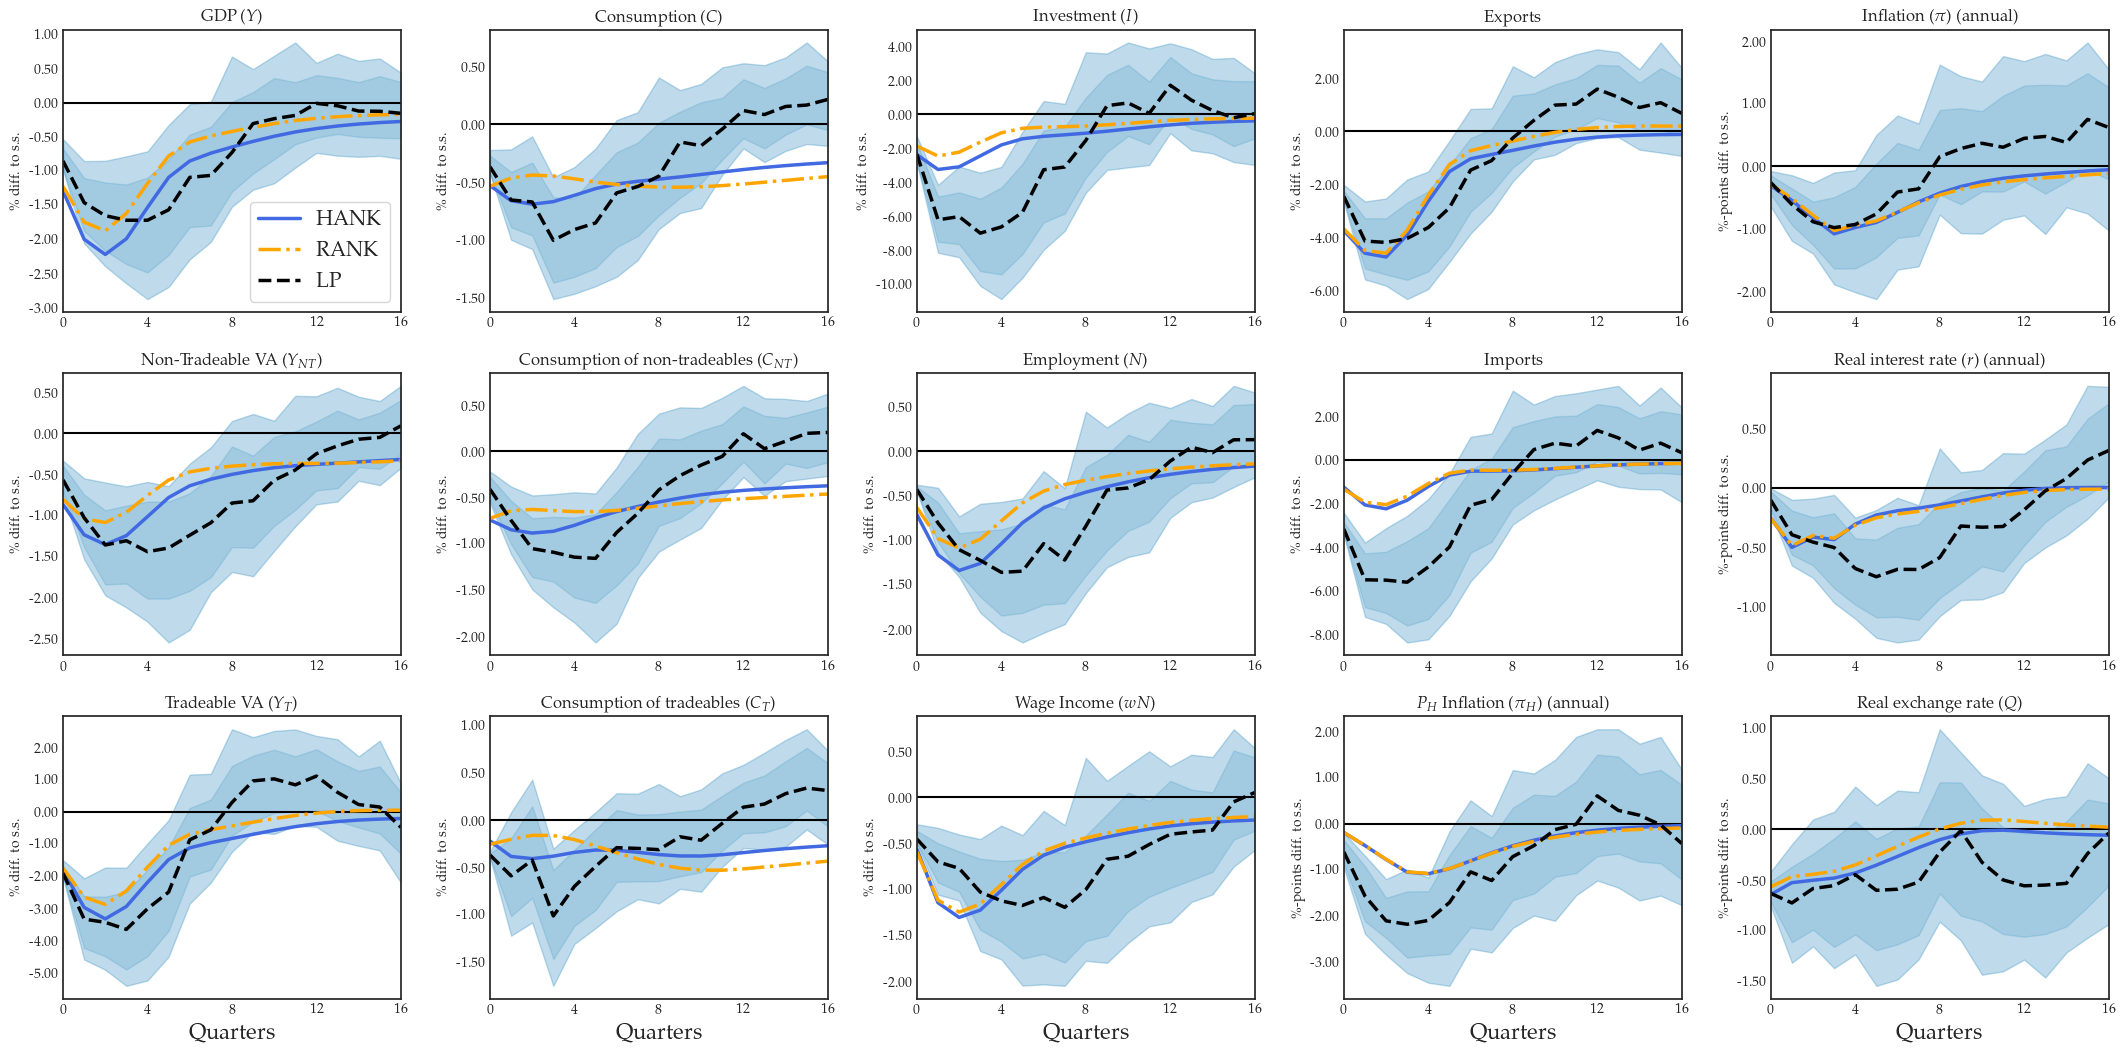

In [12]:
fig = figs.show_IRFs_vs_data([model_HANK_eps_beta,model_RANK_eps_beta],labels=['HANK','RANK'],data=model_HANK.data)
fig.savefig(r'plots/correlated_shocks_HANK_RANK_eps_beta.pdf')

### 3.1. <a id='toc3_1_'></a>[Only HANK](#toc0_)

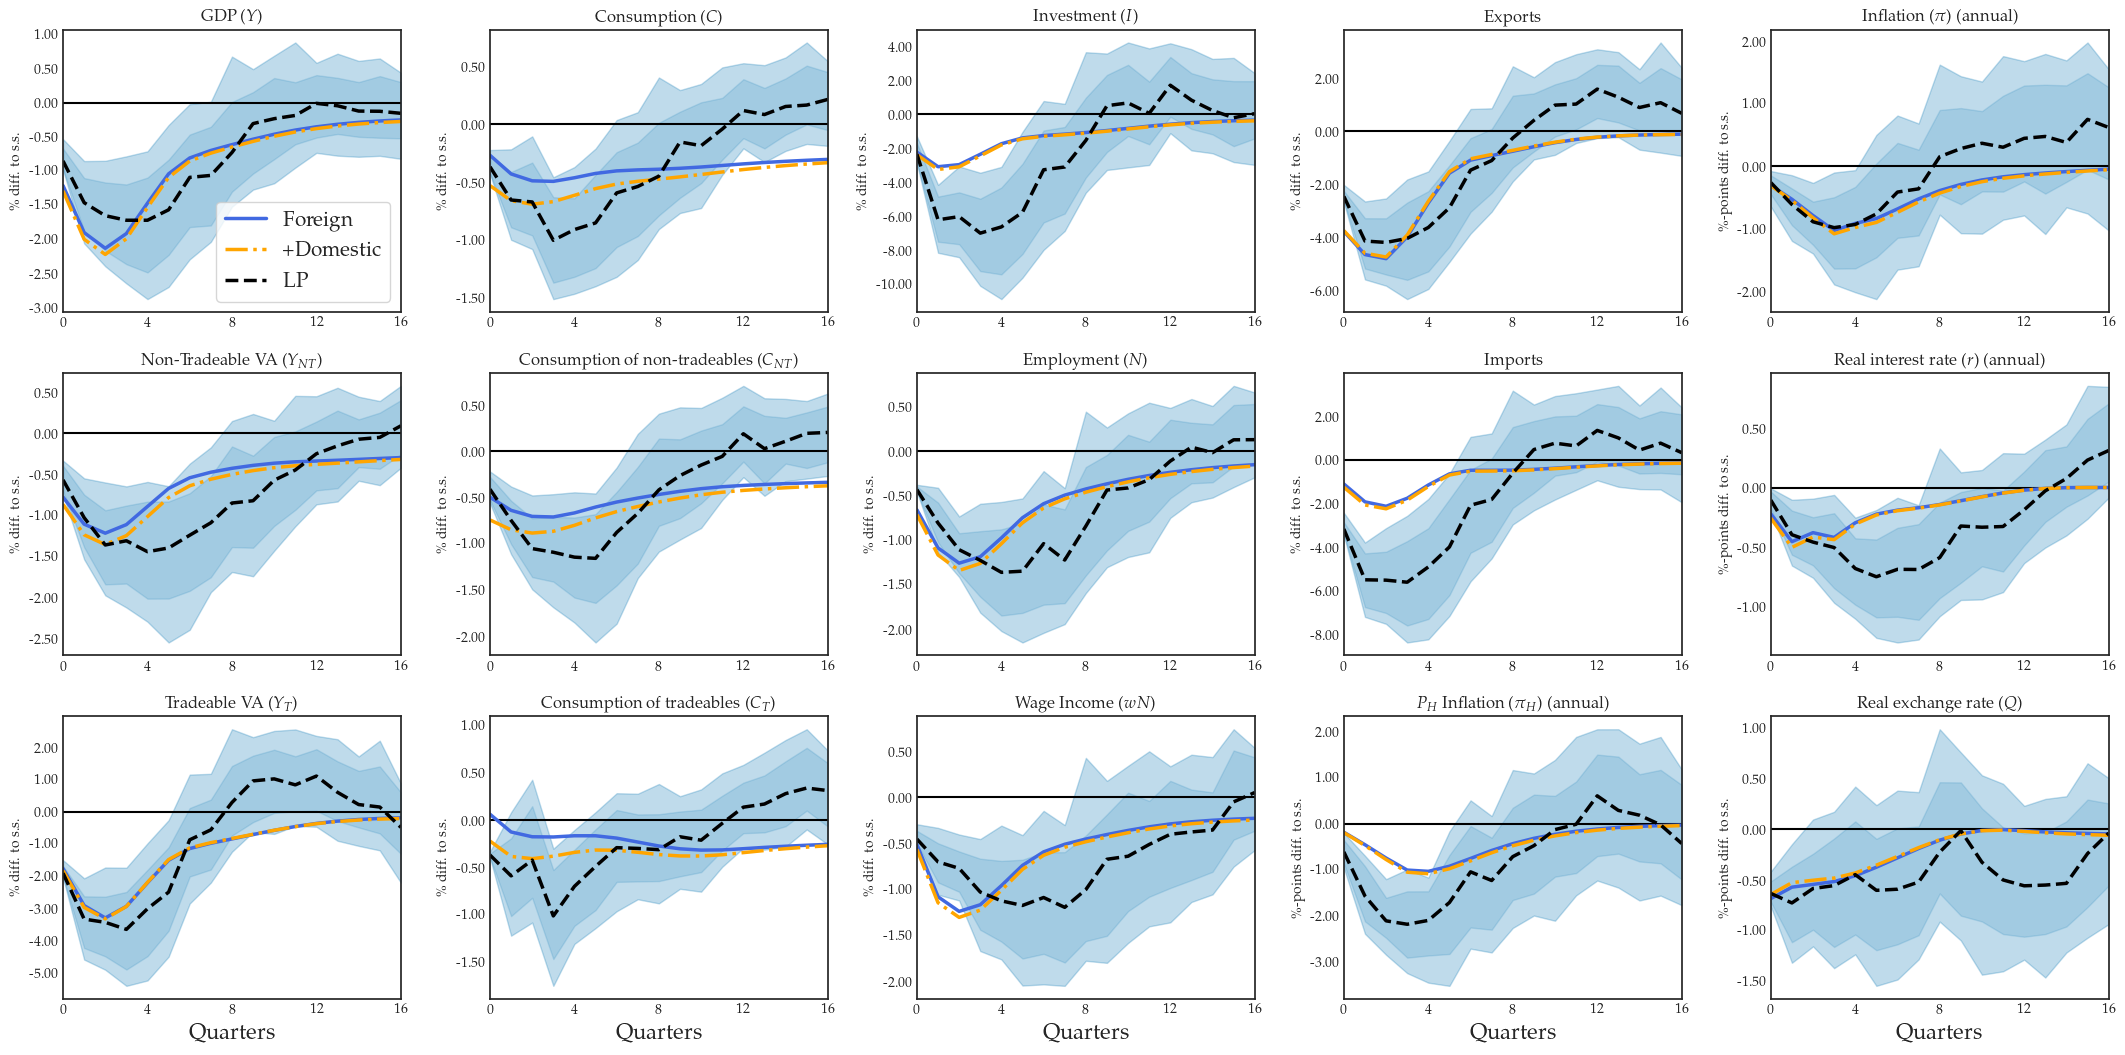

In [13]:
fig = figs.show_IRFs_vs_data([model_HANK,model_HANK_eps_beta],labels=['Foreign','+Domestic'],data=model_HANK.data)
fig.savefig(r'plots/correlated_shocks_HANK_eps_beta.pdf')